In [1]:
library(MASS)
library(nnet)
library(caret)
library(plotmo)
library(readr)
library(faraway)
library(ggplot2)
library(glmnet)
library(e1071)
library(randomForest)

Warning message:
"package 'nnet' was built under R version 3.6.3"Warning message:
"package 'caret' was built under R version 3.6.3"Loading required package: lattice
Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'plotmo' was built under R version 3.6.3"Loading required package: Formula
Loading required package: plotrix
Loading required package: TeachingDemos
Warning message:
"package 'TeachingDemos' was built under R version 3.6.3"Warning message:
"package 'readr' was built under R version 3.6.3"Warning message:
"package 'faraway' was built under R version 3.6.2"
Attaching package: 'faraway'

The following object is masked from 'package:lattice':

    melanoma

Warning message:
"package 'glmnet' was built under R version 3.6.3"Loading required package: Matrix
Loaded glmnet 3.0-2

Warning message:
"package 'e1071' was built under R version 3.6.3"Warning message:
"package 'randomForest' was built under R ver

# Load Data and Final Clean

In [2]:
df <- read.csv(file="cleaned_data_0330.csv",sep=",",header=TRUE)
df = df[,-1]
dim(df)

[1] 2470   47

## Scale and center some variables:

In [3]:
mean_age = mean(df$Start_age)
sd_age = sd(df$Start_age)
df$s_start_age = round((df$Start_age - mean_age)/sd_age,5)
mean_net = mean(df$net_cost)
sd_net = sd(df$net_cost)
df$s_net_cost = round((df$net_cost - mean_net)/sd_net,5)
mean_year = mean(df$Start_year)
sd_year = sd(df$Start_year)
df$s_start_year = round((df$Start_year - mean_year)/sd_year,5)
av_net_cost = ifelse(df$Valid.term > 0, df$net_cost / df$Valid.term, df$net_cost)
av_mean_net = mean(av_net_cost)
av_sd_net = sd(av_net_cost)
df$avs_net_cost = round((av_net_cost - av_mean_net)/av_sd_net,5)
mean_Average.Precol.GPA = mean(df$Average.Precol.GPA)
sd_Average.Precol.GPA = sd(df$Average.Precol.GPA)
df$Precol.GPA = round((df$Average.Precol.GPA - mean_Average.Precol.GPA)/sd_Average.Precol.GPA,5)
mean_GRE.Combined.General.Write.Score = mean(df$GRE.Combined.General.Write.Score)
sd_GRE.Combined.General.Write.Score = sd(df$GRE.Combined.General.Write.Score)
df$GRE_Write = round((df$GRE.Combined.General.Write.Score - mean_GRE.Combined.General.Write.Score)/sd_GRE.Combined.General.Write.Score,5)
mean_GRE.Combined.Quantitative.Score = mean(df$GRE.Combined.Quantitative.Score)
sd_GRE.Combined.Quantitative.Score = sd(df$GRE.Combined.Quantitative.Score)
df$GRE.Quant = round((df$GRE.Combined.Quantitative.Score - mean_GRE.Combined.Quantitative.Score)/sd_GRE.Combined.Quantitative.Score,5)
mean_GRE.Combined.General.Verbal.Score = mean(df$GRE.Combined.General.Verbal.Score)
sd_GRE.Combined.General.Verbal.Score = sd(df$GRE.Combined.General.Verbal.Score)
df$GRE.Verbal = round((df$GRE.Combined.General.Verbal.Score - mean_GRE.Combined.General.Verbal.Score)/sd_GRE.Combined.General.Verbal.Score,5)
mean_GMAT.Score = mean(df$GMAT.Score)
sd_GMAT.Score = sd(df$GMAT.Score)
df$GMAT.Score = round((df$GMAT.Score - mean_GMAT.Score)/sd_GMAT.Score,5)
mean_gpa = mean(df$Average_GPA)
sd_gpa = sd(df$Average_GPA)
df$average_gpa = round((df$Average_GPA - mean_gpa)/sd_gpa,2)

In [4]:
# mean_SAPC1 = mean(df$SAPC1)
# sd_SAPC1 = sd(df$SAPC1)
# df$s_SAPC1 = (df$SAPC1 - mean_SAPC1)/sd_SAPC1
# mean_SAPC2 = mean(df$SAPC2)
# sd_SAPC2 = sd(df$SAPC2)
# df$s_SAPC2 = (df$SAPC2 - mean_SAPC2)/sd_SAPC2
# mean_SAPC3 = mean(df$SAPC3)
# sd_SAPC3 = sd(df$SAPC3)
# df$s_SAPC3 = (df$SAPC3 - mean_SAPC3)/sd_SAPC3

##  Add No GRE Indicator

In [5]:
df$has_gre = C(factor(ifelse(df$GRE.Quant == 0,1,0)),treatment)
df$has_gre1 = C(factor(ifelse(df$GRE.Quant == 0,0,1)),treatment)

## Seperate by School

Different Schools

In [6]:
schools = levels(factor(df$College))

In [7]:
Harpur_df = df[df$College %in% schools[1:4],]
Management_df = df[df$College=="GD Management",]
Nursing_df = df[df$College=="GD Nursing",]
Watson_df = df[df$College=="GD Watson",]

In [8]:
unique(Harpur_df$Major)

[1] Translation Studies            Chemistry                     
 [3] Behavioral Neuroscience        Cognitive Psychology          
 [5] Physics                        Mathematics                   
 [7] Comparative Literature         Educational Theory and Practic
 [9] Philosophy Interpretation and  Biological Sciences           
[11] English                        Materials Science and Engineer
[13] History                        Anthropology                  
[15] Sociology                      Material Sci and Eng-Engineerg
[17] Clinical Psychology            Economics                     
[19] Geology                        Philosophy SPEL               
[21] Political Science              Community and Public Affairs  
[23] Art History                    Materials Science and Engr    
[25] Biological Sciences EEB        X Geology                     
[27] Art History Combined MA PhD    Mechanical Engineering        
[29] Mathematics/Economics         
45 Levels: Anthropology Art History ... XGerontolog Clin Nurse Special

In [9]:
harpur_sciences <- c("Chemistry", "Behavioral Neuroscience","Cognitive Psychology","Physics","Mathematics",
                     "Biological Sciences","Materials Science and Engineer","Material Sci and Eng-Engineerg",
                     "Clinical Psychology","Economics","Geology","Political Science","Materials Science and Engr",
                     "Biological Sciences EEB", "X Geology","Mathematics/Economics")
harpur_arts <- c("Comparative Literature","Translation Studies","Educational Theory and Practic",
                 "Philosophy Interpretation and", "English","History","Anthropology","Sociology","Philosophy SPEL",
                 "Community and Public Affairs","Art History","Art History Combined MA PhD")

In [10]:
Harpur_sciences = Harpur_df[Harpur_df$Major %in% harpur_sciences,]
Harpur_arts = Harpur_df[Harpur_df$Major %in% harpur_arts,]

In [11]:
Harpur_sciences <- within(Harpur_sciences, Citizenship <- relevel(Citizenship, ref = "White"))
Harpur_arts <- within(Harpur_arts, Citizenship <- relevel(Citizenship, ref = "White"))
Management_df <- within(Management_df, Citizenship <- relevel(Citizenship, ref = "White"))
Watson_df <- within(Watson_df, Citizenship <- relevel(Citizenship, ref = "White"))
Nursing_df <- within(Nursing_df, Citizenship <- relevel(Citizenship, ref = "White"))

In [12]:
dim(Harpur_sciences)[1]
dim(Harpur_arts)[1]
dim(Harpur_df)[1]

[1] 861

[1] 918

[1] 1780

In [13]:
a_n = dim(Harpur_sciences)[1]
a_1 = sum(Harpur_sciences$Y)
a_0 = a_n - a_1
b_n = dim(Harpur_arts)[1]
b_1 = sum(Harpur_arts$Y)
b_0 = b_n - b_1
c_n = dim(Management_df)[1]
c_1 = sum(Management_df$Y)
c_0 = c_n - c_1
d_n = dim(Nursing_df)[1]
d_1 = sum(Nursing_df$Y)
d_0 = d_n - d_1
e_n = dim(Watson_df)[1]
e_1 = sum(Watson_df$Y)
e_0 = e_n - e_1
School = c("Harpur sciences","Harpur_arts","SOM","Nursing","Watson")
sch_total = c(a_n,b_n,c_n,d_n,e_n)
succ_total = c(a_1,b_1,c_1,d_1,e_1)
unsucc_total = c(a_0,b_0,c_0,d_0,e_0)
data.frame("School"=School,"Total"=sch_total,"Successful Graduates"=succ_total,"Unsuccessful Graduates"=unsucc_total)

School,Total,Successful.Graduates,Unsuccessful.Graduates
Harpur sciences,861,542,319
Harpur_arts,918,534,384
SOM,58,38,20
Nursing,117,72,45
Watson,515,343,172


In [14]:
Harpur_sciences$college_1 = 1
Harpur_arts$college_1 = 2
Management_df$college_1 = 5
Watson_df$college_1 = 3
Nursing_df$college_1 = 4
df1 = rbind(Harpur_sciences, Harpur_arts, Management_df, Watson_df, Nursing_df)

# Harpur Sciences Analysis

Won't use Degree column since it does not accurately show the student's major

<b> Logistic regression model:

In [241]:
log_mod_h_s = glm(Y~s_start_age+factor(Gender)+s_start_year+factor(funding_indicator)+factor(Citizenship)+
                avs_net_cost+Precol.GPA+ factor(gap_indicator)+GPA_trend+average_gpa+
                +factor(has_gre)+factor(has_gre1)*GRE_Write+factor(has_gre1)*GRE.Quant+factor(has_gre1)*GRE.Verbal,
                data=Harpur_sciences,family="binomial")
# round(summary(log_mod_h_s)$coeff[which(summary(log_mod_h_s)$coef[,4] <= .05),c(1,4)],5)

<b> Both BIC

In [242]:
log_mod_h_s_bic = stepAIC(log_mod_h_s, direction = "both", k = log(b_n),trace=0)

In [243]:
round(summary(log_mod_h_s_bic)$coeff[which(summary(log_mod_h_s_bic)$coef[,4] <= .05),c(1,4)],5)

,Estimate,Pr(>|z|)
s_start_year,-1.33439,0.00000
factor(funding_indicator)1,1.10597,0.00001
avs_net_cost,0.40391,0.00083
average_gpa,0.41468,0.00001


In [244]:
summary(log_mod_h_s_bic)


Call:
glm(formula = Y ~ s_start_year + factor(funding_indicator) + 
    avs_net_cost + average_gpa, family = "binomial", data = Harpur_sciences)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.3969  -0.9619   0.5772   0.8600   2.2088  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -0.05770    0.21340  -0.270  0.78685    
s_start_year               -1.33439    0.12875 -10.364  < 2e-16 ***
factor(funding_indicator)1  1.10597    0.24726   4.473 7.72e-06 ***
avs_net_cost                0.40391    0.12083   3.343  0.00083 ***
average_gpa                 0.41468    0.09543   4.345 1.39e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1135.18  on 860  degrees of freedom
Residual deviance:  962.76  on 856  degrees of freedom
AIC: 972.76

Number of Fisher Scoring iterations: 4


# Harpur Arts Analysis

<b> Logistic regression model:

In [245]:
log_mod_h_a = glm(Y~s_start_age+factor(Gender)+s_start_year+factor(funding_indicator)+factor(Citizenship)+
                avs_net_cost+Precol.GPA+ factor(gap_indicator)+GPA_trend+average_gpa+
                +factor(has_gre)+factor(has_gre1)*GRE_Write+factor(has_gre1)*GRE.Quant+factor(has_gre1)*GRE.Verbal,
                data=Harpur_arts,family="binomial")

<b> Both AIC:

In [246]:
# log_mod_h_a_aic = stepAIC(log_mod_h_a, direction = 'both')
# round(summary(log_mod_h_a_aic)$coeff[which(summary(log_mod_h_a_aic)$coef[,4] <= .05),c(1,4)],5)

<b> Both BIC

In [247]:
log_mod_h_a_bic = stepAIC(log_mod_h_a, direction = "both", k = log(b_n),trace=0)

<b> Significant variables both BIC selects:

In [248]:
summary(log_mod_h_a_bic)


Call:
glm(formula = Y ~ s_start_year + factor(funding_indicator) + 
    average_gpa + factor(has_gre), family = "binomial", data = Harpur_arts)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8295  -1.1350   0.7538   0.9647   1.8477  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -0.74585    0.18548  -4.021 5.79e-05 ***
s_start_year               -0.25131    0.08054  -3.120 0.001806 ** 
factor(funding_indicator)1  0.67883    0.17227   3.941 8.13e-05 ***
average_gpa                 0.31227    0.09436   3.309 0.000935 ***
factor(has_gre)1            0.89446    0.18848   4.746 2.08e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1248.0  on 917  degrees of freedom
Residual deviance: 1158.9  on 913  degrees of freedom
AIC: 1168.9

Number of Fisher Scoring iterations: 4


# Management Analysis

<b> Logistic regression model:

In [249]:
log_mod_m = glm(Y~s_start_age+factor(Gender)+s_start_year+factor(Citizenship)+
                avs_net_cost+Precol.GPA+ factor(gap_indicator)+GPA_trend+average_gpa+
                +factor(has_gre)+factor(has_gre1)*GRE_Write+factor(has_gre1)*GRE.Quant+factor(has_gre1)*GRE.Verbal,
                data=Management_df,family="binomial")

<b> Both BIC:

In [250]:
log_mod_m_bic = stepAIC(log_mod_m, direction = "both", k = log(c_n),trace=0)

<b> Significant variables both BIC selects:

In [251]:
round(summary(log_mod_m_bic)$coeff[which(summary(log_mod_m_bic)$coef[,4] <= .05),c(1,4)],5)
summary(log_mod_m_bic)

,Estimate,Pr(>|z|)
(Intercept),-2.62893,0.00680
s_start_age,2.00724,0.02719
average_gpa,7.07830,0.00028
factor(has_gre)1,3.13347,0.00263



Call:
glm(formula = Y ~ s_start_age + average_gpa + factor(has_gre), 
    family = "binomial", data = Management_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1868  -0.5733   0.2320   0.5893   1.9024  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -2.6289     0.9714  -2.706 0.006803 ** 
s_start_age        2.0072     0.9087   2.209 0.027186 *  
average_gpa        7.0783     1.9458   3.638 0.000275 ***
factor(has_gre)1   3.1335     1.0416   3.008 0.002626 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 74.726  on 57  degrees of freedom
Residual deviance: 41.303  on 54  degrees of freedom
AIC: 49.303

Number of Fisher Scoring iterations: 6


# Nursing Analysis

<b> Logistic regression model:

In [252]:
log_mod_n = glm(Y~s_start_age+factor(Gender)+s_start_year+factor(funding_indicator)+
                avs_net_cost+Precol.GPA+ factor(gap_indicator)+GPA_trend+average_gpa+
                +factor(has_gre1)*GRE_Write+factor(has_gre1)*GRE.Quant+factor(has_gre1)*GRE.Verbal,
                data=Nursing_df,family="binomial")

<b> Both BIC:

In [253]:
log_mod_n_bic = stepAIC(log_mod_n, direction = "both", k = log(d_n),trace=0)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

In [254]:
summary(log_mod_n_bic)


Call:
glm(formula = Y ~ s_start_year + average_gpa + factor(has_gre1), 
    family = "binomial", data = Nursing_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1675  -1.0764   0.3518   0.9639   2.4148  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)   
(Intercept)          0.5469     0.2602   2.102  0.03557 * 
s_start_year        -0.7407     0.2732  -2.711  0.00671 **
average_gpa          0.6010     0.3179   1.890  0.05871 . 
factor(has_gre1)1   17.4553  1181.6295   0.015  0.98821   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 155.91  on 116  degrees of freedom
Residual deviance: 126.66  on 113  degrees of freedom
AIC: 134.66

Number of Fisher Scoring iterations: 16


# Watson Analysis 

<b> Logistic regression model:

In [255]:
log_mod_w = glm(Y~s_start_age+factor(Gender)+s_start_year+factor(funding_indicator)+factor(Citizenship)+
                avs_net_cost+Precol.GPA+ factor(gap_indicator)+GPA_trend+average_gpa+
                +factor(has_gre)+factor(has_gre1)*GRE_Write+factor(has_gre1)*GRE.Quant+factor(has_gre1)*GRE.Verbal,
                data=Watson_df,family="binomial")

<b> Both BIC:

In [256]:
log_mod_w_bic = stepAIC(log_mod_w, direction = "both", k = log(e_n),trace=0)

<b> Significant variables both BIC selects:

In [257]:
summary(log_mod_w_bic)


Call:
glm(formula = Y ~ s_start_year + factor(funding_indicator) + 
    avs_net_cost, family = "binomial", data = Watson_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8893  -0.9101   0.5567   0.8484   1.7719  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -0.5034     0.2001  -2.516   0.0119 *  
s_start_year                -1.0004     0.1437  -6.963 3.34e-12 ***
factor(funding_indicator)1   2.0988     0.2644   7.939 2.04e-15 ***
avs_net_cost                 0.3515     0.1548   2.270   0.0232 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 656.07  on 514  degrees of freedom
Residual deviance: 551.63  on 511  degrees of freedom
AIC: 559.63

Number of Fisher Scoring iterations: 4


In [258]:
yyy = mean(df$s_start_year)
fi = 0
cost = mean(df$avs_net_cost)
ggg = data.frame("s_start_year"=yyy,"funding_indicator"=fi,"avs_net_cost"=cost)
predict(log_mod_w_bic, newdata=ggg,type="response")

1 
0.3767468

In [259]:
predict(log_mod_w_bic, newdata=ggg,type="response")

1 
0.3767468

In [260]:
(odds = exp(.2))
(odds)/(1+odds)

[1] 1.221403

[1] 0.549834

In [261]:
sd(df$Average_GPA)

[1] 0.7789857

# Joint Analysis

<b> Logistic regression model:

In [262]:
# int_chn = function(x) ifelse(x=='China',1,0)
# int_afc = function(x) ifelse(x=='Africa',1,0)
# int_asia = function(x) ifelse(x=='Asia',1,0)
# df <- within(df, s_Citizenship <- relevel(s_Citizenship, ref = "White"))
# df <- within(df, s_College <- relevel(s_College, ref = "GD Non-Harpur"))

In [263]:
df1$Citizenship = C(df1$Citizenship,sum)
df1$college <- C(factor(df1$college_1),sum)

In [264]:
df1$ha_wa = C(factor(ifelse(df1$college_1 %in% c(1,5),1,0)),sum)
df1$is_som = C(factor(ifelse(df1$college_1 == 3,1,0)),sum)
df1$a_s_n = C(factor(ifelse(df1$college_1 %in% c(2,3,4),1,0)),sum)
df1$is_nurse = C(factor(ifelse(df1$college_1 == 4,1,0)),sum)

In [265]:
df1$has_gre = C(df1$has_gre,treatment)

In [266]:
log_mod_total = glm(Y~s_start_age+factor(Gender)+s_start_year+factor(funding_indicator)+factor(Citizenship)+
                avs_net_cost+Precol.GPA+ factor(gap_indicator)+GPA_trend+average_gpa+
                +factor(has_gre)+GRE_Write+GRE.Quant+GRE.Verbal+college,
                data=df1,family="binomial")

<b> Both BIC:

In [267]:
log_mod_total_bic = stepAIC(log_mod_total, direction = "both", k = log(e_n),trace=0)

<b>Significant variables both BIC selects:

In [268]:
summary(log_mod_total_bic)


Call:
glm(formula = Y ~ s_start_year + factor(funding_indicator) + 
    avs_net_cost + Precol.GPA + GPA_trend + average_gpa + factor(has_gre) + 
    GRE_Write + college, family = "binomial", data = df1)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5970  -1.0903   0.6496   0.9174   2.1561  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -0.351975   0.144814  -2.431  0.01508 *  
s_start_year               -0.595698   0.067106  -8.877  < 2e-16 ***
factor(funding_indicator)1  0.966458   0.117345   8.236  < 2e-16 ***
avs_net_cost                0.154880   0.048185   3.214  0.00131 ** 
Precol.GPA                  0.131529   0.046570   2.824  0.00474 ** 
GPA_trend                   0.875739   0.272290   3.216  0.00130 ** 
average_gpa                 0.337687   0.051908   6.505 7.75e-11 ***
factor(has_gre)1            0.496923   0.120302   4.131 3.62e-05 ***
GRE_Write                  -0.136074   0.04599

In [269]:
-.006 + .41 -.23 -.22

[1] -0.046

# Prediction

In [69]:
df_save = df

In [70]:
df = df_save

In [71]:
colnames(df)

[1] "Y"                 "Age"               "has_gre"          
 [4] "Gender"            "Average_GPA"       "s_start_year"     
 [7] "s_Citizenship"     "avs_net_cost"      "Gender.1"         
[10] "College"           "funding_indicator" "Citizenship"      
[13] "gap_indicator"     "GPA_trend"

In [72]:
column_to_keep_name = c('Y','Age','has_gre','Gender','Average_GPA','s_start_year','s_Citizenship','avs_net_cost','Gender','s_Average.Precol.GPA','s_GRE.Combined.General.Write.Score','s_GRE.Combined.Quantitative.Score','s_GRE.Combined.General.Verbal.Score','College','funding_indicator','Citizenship','gap_indicator','GPA_trend')
column_to_keep = NULL
for (i in 1:length(column_to_keep_name)){
    column_to_keep = c(column_to_keep,which(colnames(df)==column_to_keep_name[i]))
}

In [73]:
df = df[,column_to_keep]
colnames(df)

[1] "Y"                 "Age"               "has_gre"          
 [4] "Gender"            "Average_GPA"       "s_start_year"     
 [7] "s_Citizenship"     "avs_net_cost"      "Gender.1"         
[10] "College"           "funding_indicator" "Citizenship"      
[13] "gap_indicator"     "GPA_trend"

In [74]:
set.seed(123)
s1 = sample(nrow(df),0.5*nrow(df))
train = df[s1,]
non_train = df[-s1,]
s2 = sample(nrow(non_train),0.5*nrow(non_train))
test = non_train[s2,]
vld = non_train[-s2,]

train_y=train[,1]
train_x=train[,-1]
test_y=test[,1]
test_x=test[,-1]
vld_y=vld[,1]
vld_x=vld[,-1]
dim(train)
dim(test)

[1] 1235   14

[1] 617  14

## Random Forest

In [75]:
library("randomForest")
n<-length(names(train)) 
rate=1
for(i in 1:(n-1)){
  set.seed(1234)
  rf_train<-randomForest(as.factor(train$Y)~.,data=train,mtry=i,ntree=1000)
  rate[i]<-mean(rf_train$err.rate)  
  print(rf_train)    
}


Call:
 randomForest(formula = as.factor(train$Y) ~ ., data = train,      mtry = i, ntree = 1000) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 1

        OOB estimate of  error rate: 29.23%
Confusion matrix:
    0   1 class.error
0 106 356 0.770562771
1   5 768 0.006468305

Call:
 randomForest(formula = as.factor(train$Y) ~ ., data = train,      mtry = i, ntree = 1000) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 2

        OOB estimate of  error rate: 22.27%
Confusion matrix:
    0   1 class.error
0 239 223  0.48268398
1  52 721  0.06727038

Call:
 randomForest(formula = as.factor(train$Y) ~ ., data = train,      mtry = i, ntree = 1000) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 3

        OOB estimate of  error rate:

[1] 0.3539499 0.2632136 0.2617480 0.2680412 0.2678396 0.2668026 0.2640318
 [8] 0.2682477 0.2688650 0.2707960 0.2724711 0.2696797 0.2681990

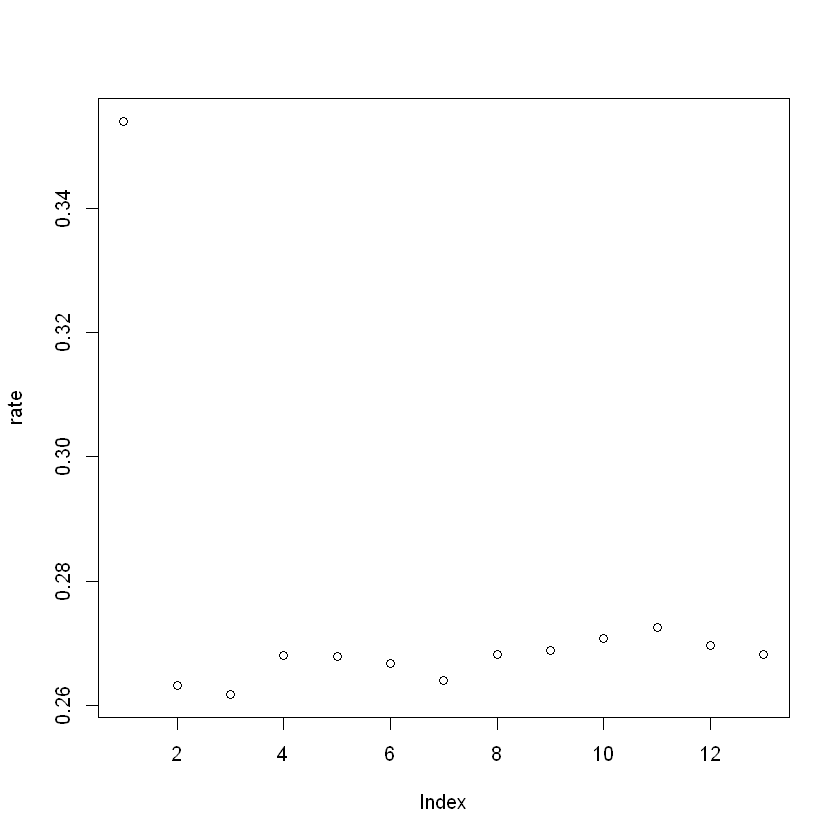

In [76]:
rate  
plot(rate)

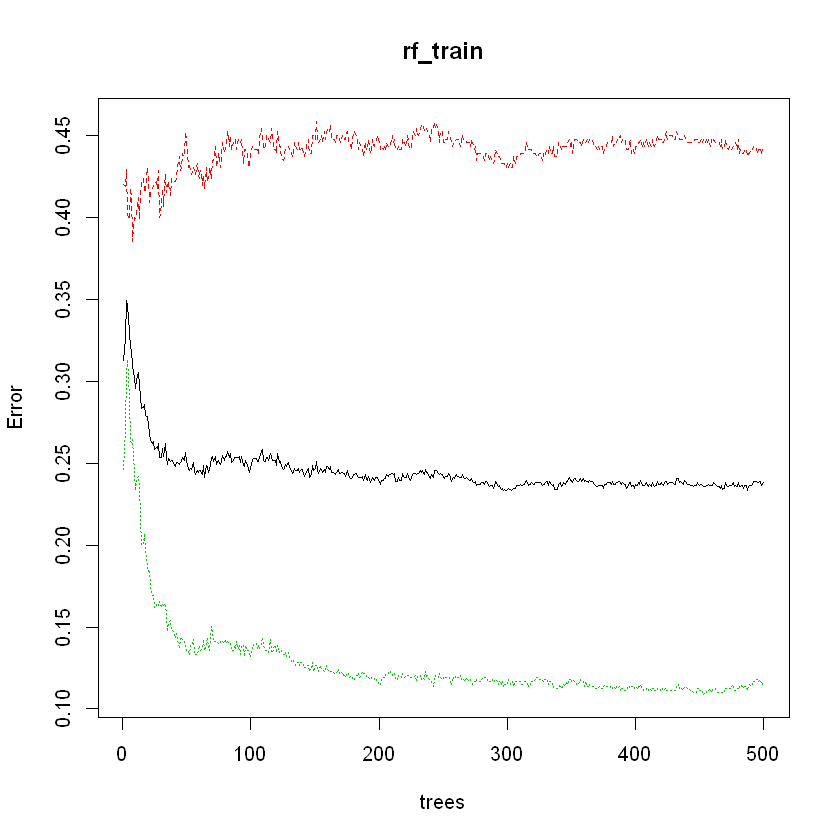

In [77]:
rf_train<-randomForest(as.factor(train$Y)~.,data=train,mtry=6)
plot(rf_train)    
legend(800,0.02,"Y=0",cex=0.9,bty="n")    
legend(800,0.0245,"total",cex=0.09,bty="n")   

In [78]:
set.seed(100)
rf_train<-randomForest(train$Y~.,data=as.data.frame(train),mtry = 6,importance=TRUE)
rf_train

Warning message in randomForest.default(m, y, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"


Call:
 randomForest(formula = train$Y ~ ., data = as.data.frame(train),      mtry = 6, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 6

          Mean of squared residuals: 0.1717739
                    % Var explained: 26.64

In [79]:
rf_pred = as.numeric(predict(rf_train, newdata = test)>= .7)
(rf_acc = round(sum(rf_pred == test$Y)/length(rf_pred),4))

rf_pred_0 = as.numeric(predict(rf_train, newdata = test[which(test$Y==0),])>= .7)
(rf_acc_0 = round(sum(rf_pred_0 == test[which(test$Y==0),]$Y)/length(rf_pred_0),4))

[1] 0.6904

[1] 0.7359

,%IncMSE,IncNodePurity
Age,18.815925,29.912069
has_gre,14.706348,4.738738
Gender,4.626522,3.209897
Average_GPA,49.842928,55.081529
s_start_year,44.711798,42.425472
s_Citizenship,7.529039,4.142707
avs_net_cost,23.616599,43.153076
Gender.1,3.181000,3.406507
College,12.113314,12.550009
funding_indicator,11.059233,4.547292


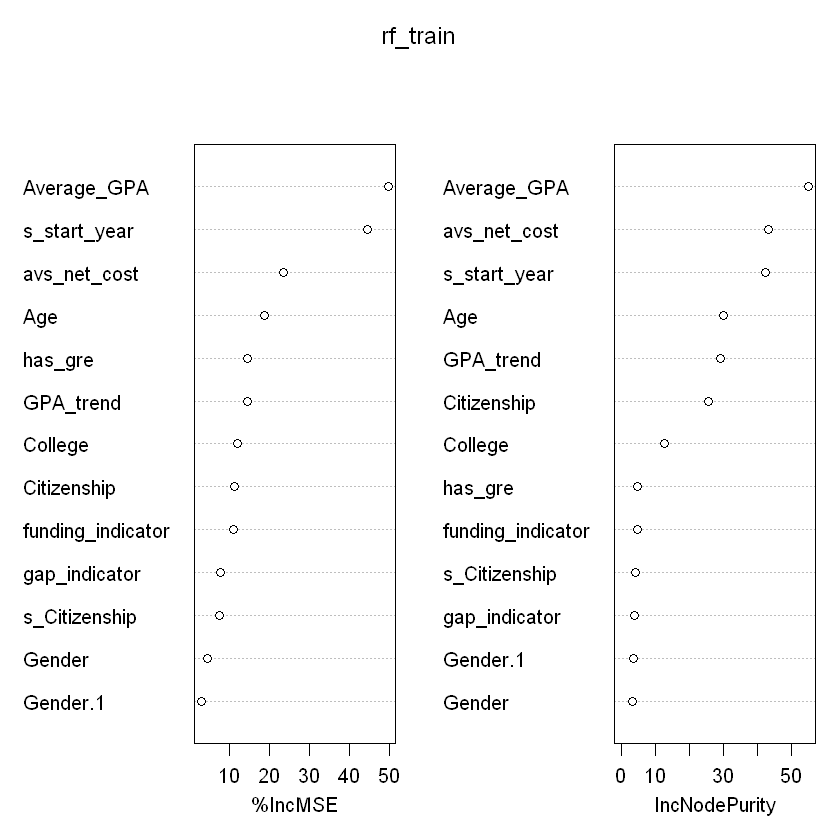

In [80]:
importance(rf_train)
varImpPlot(rf_train)

## LDA

In [81]:
mod_lda = lda(Y~., data = as.data.frame(train),prior=c(0.3741,0.6259)/1)
lda_pred = predict(mod_lda, newdata = test)
(lda_acc = round(sum(lda_pred$class == test$Y)/length(lda_pred$class),4))

lda_pred_0 = predict(mod_lda, newdata = test[which(test$Y==0),])
(lda_acc_0 = round(sum(lda_pred_0$class == test[which(test$Y==0),]$Y)/length(lda_pred_0$class),4))

Warning message in lda.default(x, grouping, ...):
"variables are collinear"Warning message:
"contrasts dropped from factor has_gre"

[1] 0.6985

Warning message:
"contrasts dropped from factor has_gre"

[1] 0.3636

<b> Summary

In [82]:
mod_lda$scaling

,LD1
Age,0.01079143
has_gre1,0.41679976
GenderMale,0.15626407
Average_GPA,0.64960708
s_start_year,-0.59099538
s_CitizenshipAsia,-0.21365791
s_CitizenshipChina,-0.29044202
s_CitizenshipWhite,-0.70664157
avs_net_cost,0.07093690
Gender.1Male,0.15626407


## Neural Network

In [83]:
nnet_vld = NULL
for (i in seq(1,10,1)){
    mod_nnet = nnet(Y~., data = train, size  = i,trace = FALSE, decay =.1, rang = 0, maxit = 250)
    nn_pred = predict(mod_nnet, newdata = vld)
    nn_pred = as.numeric(nn_pred>=.7)
    nnet_vld = c(nnet_vld, sum(nn_pred == vld$Y)/length(nn_pred))
}
(tr_size = which.max(nnet_vld))

Warning message:
"contrasts dropped from factor has_gre"Warning message:
"contrasts dropped from factor has_gre"Warning message:
"contrasts dropped from factor has_gre"Warning message:
"contrasts dropped from factor has_gre"Warning message:
"contrasts dropped from factor has_gre"Warning message:
"contrasts dropped from factor has_gre"Warning message:
"contrasts dropped from factor has_gre"Warning message:
"contrasts dropped from factor has_gre"Warning message:
"contrasts dropped from factor has_gre"Warning message:
"contrasts dropped from factor has_gre"

[1] 8

In [84]:
mod_nnet = nnet(Y~., data = train, size  = tr_size,trace = FALSE, decay =.1, rang = 0, maxit = 250)
nn_pred = as.numeric(predict(mod_nnet, newdata = test)>= .7)
(nnet_acc = round(sum(nn_pred == test$Y)/length(nn_pred),4))

nn_pred_0 = as.numeric(predict(mod_nnet, newdata = test[which(test$Y==0),])>= .7)
(nnet_acc_0 = round(sum(nn_pred_0 == test[which(test$Y==0),]$Y)/length(nn_pred_0),4))

Warning message:
"contrasts dropped from factor has_gre"

[1] 0.6694

Warning message:
"contrasts dropped from factor has_gre"

[1] 0.7619

<b> Summary

In [85]:
summary(mod_nnet)

a 29-8-1 network with 249 weights
options were - decay=0.1
  b->h1  i1->h1  i2->h1  i3->h1  i4->h1  i5->h1  i6->h1  i7->h1  i8->h1  i9->h1 
   2.64   -0.10   -0.90   -0.56    0.45    1.35    0.14    0.88    1.51   -0.39 
i10->h1 i11->h1 i12->h1 i13->h1 i14->h1 i15->h1 i16->h1 i17->h1 i18->h1 i19->h1 
  -0.56    1.55   -0.43   -0.63    0.58    0.30    0.08   -0.60    0.14    0.43 
i20->h1 i21->h1 i22->h1 i23->h1 i24->h1 i25->h1 i26->h1 i27->h1 i28->h1 i29->h1 
   0.42    0.88    0.29   -0.24    0.51   -0.43    0.48    0.06    1.06    0.87 
  b->h2  i1->h2  i2->h2  i3->h2  i4->h2  i5->h2  i6->h2  i7->h2  i8->h2  i9->h2 
  -0.22    0.10   -1.05   -0.28   -0.34   -2.75   -0.26    0.09    0.36    1.61 
i10->h2 i11->h2 i12->h2 i13->h2 i14->h2 i15->h2 i16->h2 i17->h2 i18->h2 i19->h2 
  -0.28   -0.08    0.54    1.81   -1.30    0.98   -1.26    0.59   -0.26    0.80 
i20->h2 i21->h2 i22->h2 i23->h2 i24->h2 i25->h2 i26->h2 i27->h2 i28->h2 i29->h2 
  -0.79    0.09    0.45    0.61   -1.18   -0.51   

## Logistic Regression

In [86]:
mod_glm = glm(Y~., data = train, family=binomial())

glm_pred = as.numeric(predict(mod_glm, newdata = test, type="response") >= .7)
(glm_acc = round(sum(glm_pred == test$Y)/length(glm_pred),4))

glm_pred_0 = as.numeric(predict(mod_glm, newdata = test[which(test$Y==0),], type="response") >= .7)
(glm_acc_0 = round(sum(glm_pred_0 == test[which(test$Y==0),]$Y)/length(glm_pred_0),4))

Warning message:
"contrasts dropped from factor has_gre"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"

[1] 0.5786

Warning message:
"contrasts dropped from factor has_gre"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"

[1] 0.684

<b> Summary

In [87]:
summary(mod_glm)


Call:
glm(formula = Y ~ ., family = binomial(), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4049  -1.0721   0.6289   0.8921   2.5243  

Coefficients: (4 not defined because of singularities)
                                        Estimate Std. Error z value Pr(>|z|)
(Intercept)                             -2.41926    1.14278  -2.117  0.03426
Age                                      0.00851    0.01014   0.840  0.40111
has_gre1                                 0.27105    0.18345   1.478  0.13954
GenderMale                               0.27815    0.13981   1.990  0.04664
Average_GPA                              0.66252    0.11813   5.608 2.04e-08
s_start_year                            -0.60166    0.11350  -5.301 1.15e-07
s_CitizenshipAsia                       -0.53539    0.58851  -0.910  0.36296
s_CitizenshipChina                      -0.68177    0.59216  -1.151  0.24960
s_CitizenshipWhite                      -1.04906    0.56153  -1.868  0.061

## SVM

In [88]:
mod_svm = svm(Y~., data = train, family=binomial())

svm_pred = as.numeric(predict(mod_svm, newdata = test, type="response") >= .7)
(svm_acc = round(sum(svm_pred == test$Y)/length(svm_pred),4))

svm_pred_0 = as.numeric(predict(mod_svm, newdata = test[which(test$Y==0),], type="response") >= .7)
(svm_acc_0 = round(sum(svm_pred_0 == test[which(test$Y==0),]$Y)/length(svm_pred_0),4))

[1] 0.718

[1] 0.4805

<b> Summary

In [89]:
summary(mod_svm)
colMeans(mod_svm$SV)
#The resulting support vectors (possibly scaled).


Call:
svm(formula = Y ~ ., data = train, family = binomial())


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.03333333 
    epsilon:  0.1 


Number of Support Vectors:  983






Age                                has_gre0 
                           -0.023325778                             0.467955239 
                               has_gre1                              GenderMale 
                            0.532044761                             0.541200407 
                            Average_GPA                            s_start_year 
                           -0.050192926                             0.104300964 
                      s_CitizenshipAsia                      s_CitizenshipChina 
                            0.128179044                             0.128179044 
                     s_CitizenshipWhite                            avs_net_cost 
                            0.721261445                             0.013075052 
                           Gender.1Male                     CollegeGD.Education 
                            0.541200407                             0.028484232 
                  CollegeGD.Grad.School                        CollegeGD.Harpur 
                            0.021363174                             0.655137335 
                   CollegeGD.Management                       CollegeGD.Nursing 
                            0.023397762                             0.050864700 
                       CollegeGD.Watson                       funding_indicator 
                            0.209562564                            -0.027743951 
                        CitizenshipAsia                        CitizenshipAsian 
                            0.128179044                             0.043743642 
   CitizenshipBlack.or.African.American                        CitizenshipChina 
                            0.033570702                             0.128179044 
                      CitizenshipEurope           CitizenshipHispanic.or.Latino 
                            0.021363174                             0.041709054 
                       CitizenshipIndia CitizenshipOther.International.Students 
                            0.044760936                             0.017293998 
                     CitizenshipUnknown                        CitizenshipWhite 
                            0.069175992                             0.449643947 
                          gap_indicator                               GPA_trend 
                           -0.020300515                            -0.005378373

## LASSO

In [90]:
train_x = model.matrix(~., data = train_x)
test_x = model.matrix(~., data = test_x)

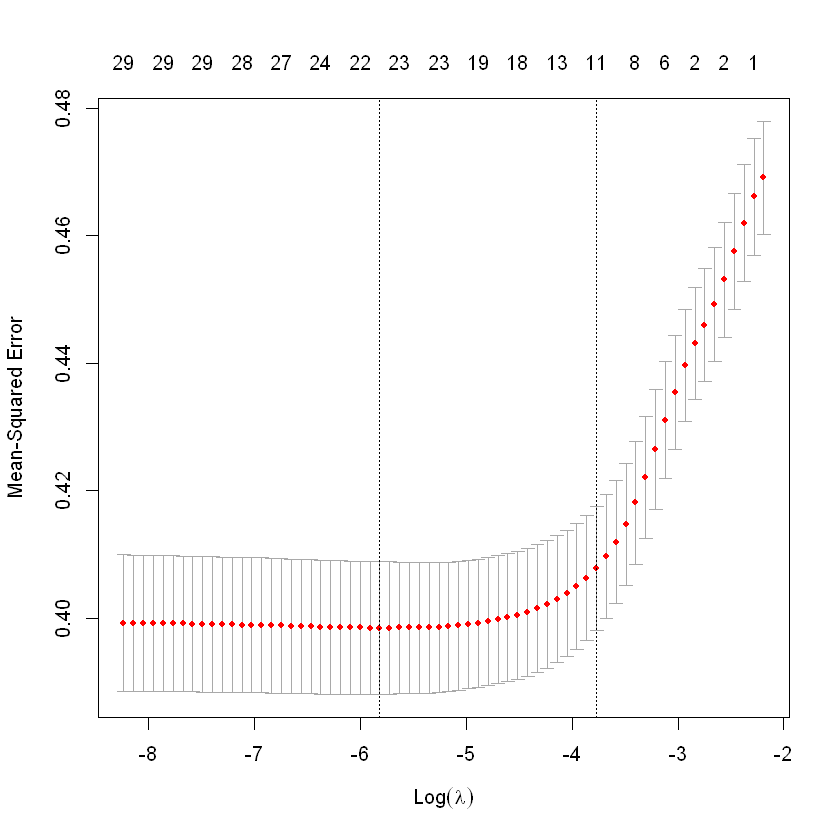

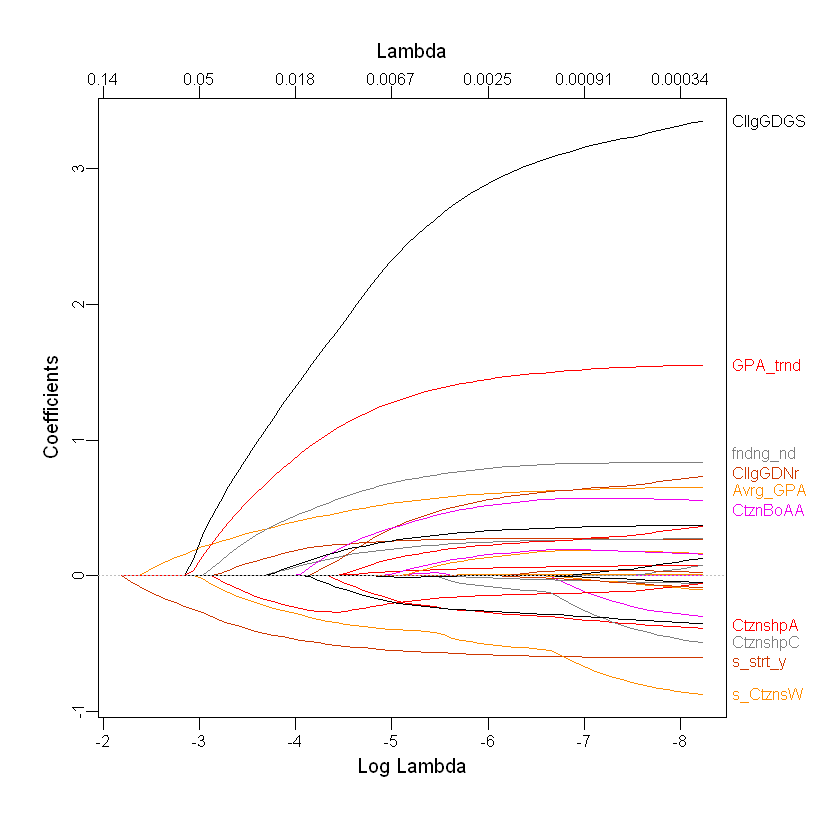

In [91]:
cvfit = cv.glmnet(train_x,train_y,alpha=1,family='binomial',type.measure='mse')
mod_lasso = glmnet(train_x,train_y,alpha=1, family = "binomial",lambda = cvfit$lambda)
plot(cvfit)
plot_glmnet(mod_lasso)
mod_lasso <- glmnet(train_x,train_y,alpha=1, family = "binomial",lambda = cvfit$lambda.min)

In [92]:
lasso_pred = predict(mod_lasso, test_x, type="class")>=0.7
lasso_right = colSums(lasso_pred == test_y)
(lasso_acc = round(max(lasso_right)/length(test_y),4))

lasso_pred_0 = predict(mod_lasso, test_x[which(test_y==0),], type="class")>=0.7
lasso_right_0 = colSums(lasso_pred_0 == test_y[which(test_y==0)])
(lasso_acc_0 = round(max(lasso_right_0)/length(test_y[which(test_y==0)]),4))

[1] 0.7131

[1] 0.3896

<b> Summary

In [93]:
mod_lasso$beta

30 x 1 sparse Matrix of class "dgCMatrix"
                                                  s0
(Intercept)                              .          
Age                                      0.007043461
has_gre1                                 0.272754119
GenderMale                               0.082803258
Average_GPA                              0.596532564
s_start_year                            -0.576729795
s_CitizenshipAsia                        .          
s_CitizenshipChina                       .          
s_CitizenshipWhite                      -0.486543719
avs_net_cost                             0.054455631
Gender.1Male                             0.164754136
CollegeGD Education                      .          
CollegeGD Grad School                    2.818800642
CollegeGD Harpur                        -0.148606575
CollegeGD Management                     .          
CollegeGD Nursing                        0.537691407
CollegeGD Watson                         0.217120509
fund

## Prediction Summary

In [94]:
res = data.frame(rbind(rf_acc, lda_acc, nnet_acc, glm_acc,svm_acc,lasso_acc))
colnames(res) = 'Accuracy'
rownames(res) = c('Random Forest','LDA', 'Neural Network', 'Logistic Regression', 'SVM', 'LASSO')
res

,Accuracy
Random Forest,0.6904
LDA,0.6985
Neural Network,0.6694
Logistic Regression,0.5786
SVM,0.7180
LASSO,0.7131


In [95]:
res_0 = data.frame(rbind(rf_acc_0, lda_acc_0, nnet_acc_0, glm_acc_0,svm_acc_0,lasso_acc_0))
colnames(res_0) = 'Accuracy On Unsuccessful Students'
rownames(res_0) = c('Random Forest','LDA', 'Neural Network', 'Logistic Regression', 'SVM', 'LASSO')
res_0

,Accuracy On Unsuccessful Students
Random Forest,0.7359
LDA,0.3636
Neural Network,0.7619
Logistic Regression,0.6840
SVM,0.4805
LASSO,0.3896


In [96]:
odds = exp(1.35*5)
p = (odds)/(1+odds)
odds

[1] 854.0588